In [1]:
import csv
import math
import cv2

In [2]:
def angle(x,y,z):
    return math.atan2(math.sqrt(z**2+y**2),x)

In [3]:
from glob import glob
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import h5py
import numpy as np
from skimage.color import rgb2gray
from skimage.util import montage
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
try:
    from tqdm import tqdm
except ImportError:
    print('Missing tqdm...')
    tqdm = lambda x: x
data_dir = os.path.join('..', 'input')

In [4]:
# load the data file and extract dimensions
with h5py.File('gaze.h5','r') as t_file:
    print(list(t_file.keys()))
    assert 'image' in t_file, "Images are missing"
    assert 'look_vec' in t_file, "Look vector is missing"
    look_vec = t_file['look_vec'].value
    assert 'path' in t_file, "Paths are missing"
    print('Images found:',len(t_file['image']))
    for _, (ikey, ival) in zip(range(1), t_file['image'].items()):
        print('image',ikey,'shape:',ival.shape)
        img_width, img_height = ival.shape
    syn_image_stack = np.stack([a for a in t_file['image'].values()],0)

['image', 'look_vec', 'path']


<ipython-input-4-9e5d51f83d1d>:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  look_vec = t_file['look_vec'].value


Images found: 50000
image ..\..\..\..\Downloads\UnityEyes_Windows\UnityEyes_Windows\imgs\1.jpg shape: (35, 55)


In [5]:
head_pose = []
with open('gaze.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        temp1, temp2, temp3 = repr({row[4]}).split(", ")
        fixed1 = temp1.split("(")
        fixed3 = temp3.split(")")
        head_pose.append([round(float(fixed1[1]),4),round(float(temp2)-180,4),float(fixed3[0])])

Separting Dataset into classes

In [6]:
def to_deg(x):
    temp = x*180/math.pi
    return temp
    
def to_rad(x):
    temp = x*math.pi/180
    return temp

def vector(angle): # Use radians
    x = math.cos(angle)
    y = math.sin(angle)
    return x,y

def angle_between(angle1, angle2): #angles in degrees
    theta1 = vector(to_rad(angle1))
    theta2 = vector(to_rad(angle2))
    x, y, z = theta1[0]+theta2[1], theta1[1], theta2[0]
    return x, y, z

In [7]:
Aclass = np.zeros(50000, int)
x_train = np.zeros((40000,32,32), np.uint8)
y_train = np.zeros(40000, int)
x_test = np.zeros((10000,32,32), np.uint8)
y_test = np.zeros(10000, int)
for index in range(50000):
    #print("--HEAD ANGLE--",head_pose[index])
    head = angle_between(head_pose[index][0],head_pose[index][1])
    #print(head)
    #plt.imshow(syn_image_stack[index],cmap='gray')
    #print(syn_image_stack[index].shape)
    a,b,c,d = look_vec[index]
    #print("--AB--",a*90,b*90)
    eye = angle_between(a*90,b*90)
    #print(eye)
    x = head[0]-eye[0]
    y = head[1]-eye[1]
    z = head[2]-eye[2]
    #print(x,y,z)
    actual = to_deg(angle(x,y,z))
    Aclass[index] = int(math.floor(actual/18))
    #print("Angle:",round(actual,2))
    #print("Class:", Aclass[index])
    #if index % 1000 == 999:
        #print(index+1)
    image = syn_image_stack[index]
    crop = image[3:35, 12:44]
    if index < 40000:
        x_train[index] = crop
        y_train[index] = Aclass[index]
    else:
        x_test[index-40000] = crop
        y_test[index-40000] = Aclass[index]

In [8]:
print(Aclass)

[2 0 7 ... 6 1 2]


In [9]:
unique, counts = np.unique(Aclass, return_counts=True)
dict(zip(unique, counts))

{0: 2687,
 1: 8284,
 2: 7567,
 3: 7047,
 4: 4887,
 5: 4192,
 6: 4039,
 7: 4364,
 8: 4614,
 9: 2319}

5
(40000, 32, 32)


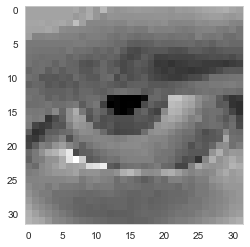

In [10]:
plt.imshow(x_train[4], cmap='gray')
print(y_train[4])
print(x_train.shape)

Neural Network

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import tensorflow.keras

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import cv2

In [13]:
x_train = x_train.reshape(x_train.shape[0],32,32,1)
x_test = x_test.reshape(x_test.shape[0],32,32,1)
print(x_train.shape)
print(x_test.shape)

(40000, 32, 32, 1)
(10000, 32, 32, 1)


In [14]:
input_size = (32,32,1)
model = models.Sequential()
model.add(layers.Conv2D(6, (5,5), activation='tanh', input_shape=input_size))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Conv2D(16, (5,5), activation='tanh'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='tanh'))
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [15]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
test = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9898 - accuracy: 0.4711
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9211 - accuracy: 0.5379
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8923 - accuracy: 0.5670
Epoch 4/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8767 - accuracy: 0.5831
Epoch 5/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8650 - accuracy: 0.5945
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8501 - accuracy: 0.6098
Epoch 7/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8452 - accuracy: 0.6156
Epoch 8/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8384 - accuracy: 0.6221
Epoch 9/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8288 - accuracy: 0.6317
Epoch 10/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.826

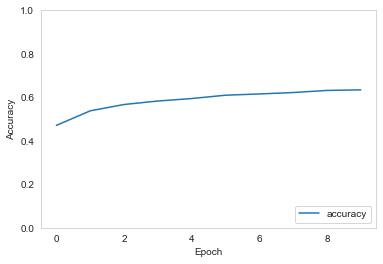

In [16]:
plt.plot(test.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig("results.jpg")

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(x_test)
result = np.zeros(predictions.shape[0])
for i in range(predictions.shape[0]):
    result[i] = np.argmax(predictions[i])
new = y_test.flatten()
print(confusion_matrix(new,result))
print(classification_report(new,result))

[[   0  506   25    4    2    0    1    0    1    0]
 [   0 1353  226   17    5    7    2    0    1    0]
 [   0  177 1046  266   12   14    1    0    0    0]
 [   0   26  235 1018  113   16    3    0    2    0]
 [   0   10   31  240  521  138   11    4    5    0]
 [   0    3    9   19  159  557  116   17    7    0]
 [   0    4    8   10   29  191  456  149   12    0]
 [   0    3    6    3   15   26  156  555  130    0]
 [   0    3    5    2    6   12   26  147  682    0]
 [   0    1    3    0    4    6    8   30  386    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       539
           1       0.65      0.84      0.73      1611
           2       0.66      0.69      0.67      1516
           3       0.64      0.72      0.68      1413
           4       0.60      0.54      0.57       960
           5       0.58      0.63      0.60       887
           6       0.58      0.53      0.56       859
           7       0.62      0.62   

C:\Users\SackOfBlubber\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
